#### Imports

In [1]:
import os

def find_path(name, path='/content'):
    '''
    поиск файла или папки
    '''
    result = []
    for root, dirs, files in os.walk(path):
        if name in files+dirs:
          result.append([os.path.join(root, name), root])
    return result

if len(find_path('MyDrive')) == 0 and True:
  from google.colab import drive
  drive.mount('/content/drive')
if True:
  os.chdir(find_path('full_train.ipynb')[0][1])

Mounted at /content/drive


In [2]:
!pip -q install --upgrade git+https://github.com/evfro/polara.git@develop#egg=polara
#! wget -q https://raw.githubusercontent.com/Personalization-Technologies-Lab/RecSys-Course-HSE-Fall23/main/Seminar5/dataprep.py -O dataprep.py
#! wget -q https://raw.githubusercontent.com/Personalization-Technologies-Lab/RecSys-Course-HSE-Fall23/main/Seminar5/evaluation.py -O evaluation.py
!pip -q install ray==2.9.0
!pip -q install Bottleneck==1.3.7
!pip -q install optuna==3.5.0
!pip -q install omegaconf==2.3.0


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.0/354.0 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [101]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
protomf_path = Path("./ProtoMF/")
sys.path.append(protomf_path.__str__())

import argparse
import os
from confs.hyper_params import mf_hyper_params, anchor_hyper_params, user_proto_chose_original_hyper_params, \
    item_proto_chose_original_hyper_params, proto_double_tie_chose_original_hyper_params
from experiment_helper import start_hyper, start_multiple_hyper
from utilities.consts import SINGLE_SEED


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [102]:
import os
import torch
from ray import tune
from torch import nn
from torch.utils import data
from feature_extraction.feature_extractor_factories import FeatureExtractorFactory
from rec_sys_folder.rec_sys import RecSys
from utilities.consts import OPTIMIZING_METRIC, MAX_PATIENCE
from utilities.eval import Evaluator
import numpy as np
import pandas as pd
from scipy import sparse as sp
from torch.utils import data
from torch.utils.data.dataset import T_co
from functools import partial
import torch
from torch import nn
from feature_extraction.feature_extractors import FeatureExtractor
import argparse
from ray import tune
from ray.tune.schedulers import ASHAScheduler
from ray.tune.search.hyperopt import HyperOptSearch
from rec_sys_folder.protomf_dataset import get_protorecdataset_dataloader
from rec_sys_folder.tester import Tester
from rec_sys_folder.trainer import Trainer
from utilities.consts import NEG_VAL, OPTIMIZING_METRIC, SEED_LIST, SINGLE_SEED, NUM_SAMPLES, \
    PROJECT_NAME, DATA_PATH, NUM_WORKERS, CPU_PER_TRIAL, GPU_PER_TRIAL, WANDB_API_KEY
from ray.air.integrations.wandb import WandbLoggerCallback
from utilities.utils import reproducible, generate_id
import platform

#### Functions (not see)

In [5]:
torch.cuda.is_available()

True

In [6]:
import wandb

In [7]:
def load_data(conf: argparse.Namespace, is_train: bool = True):
    if is_train:
        train_loader = get_protorecdataset_dataloader(
            data_path=conf.data_path,
            split_set='train',
            n_neg=conf.neg_train,
            neg_strategy=conf.train_neg_strategy,
            batch_size=conf.batch_size,
            shuffle=True,
            num_workers=NUM_WORKERS,
            prefetch_factor=5
        )

        val_loader = get_protorecdataset_dataloader(
            data_path=conf.data_path,
            split_set='val',
            n_neg=NEG_VAL,
            neg_strategy=conf.eval_neg_strategy,
            batch_size=conf.val_batch_size,
            num_workers=NUM_WORKERS
        )

        test_loader = get_protorecdataset_dataloader(
            data_path=conf.data_path,
            split_set='test',
            n_neg=NEG_VAL,
            neg_strategy=conf.eval_neg_strategy,
            batch_size=conf.val_batch_size,
            num_workers=NUM_WORKERS
        )

        return {'train_loader': train_loader, 'val_loader': val_loader, 'test_loader': test_loader}
    else:

        test_loader = get_protorecdataset_dataloader(
            data_path=conf.data_path,
            split_set='test',
            n_neg=NEG_VAL,
            neg_strategy=conf.eval_neg_strategy,
            batch_size=conf.val_batch_size,
            num_workers=NUM_WORKERS
        )

        return {'test_loader': test_loader}


def start_training(config):
    config = argparse.Namespace(**config)
    print(config)

    data_loaders_dict = load_data(config)

    reproducible(config.seed)

    # trainer = Trainer(data_loaders_dict['train_loader'], data_loaders_dict['val_loader'], data_loaders_dict['test_loader'], config)
    trainer = Trainer(data_loaders_dict['train_loader'], data_loaders_dict['val_loader'],  config)


    trainer.run()

    wandb.finish()


def start_testing(config, model_load_path: str):
    config = argparse.Namespace(**config)
    print(config)

    data_loaders_dict = load_data(config, is_train=False)

    reproducible(config.seed)

    tester = Tester(data_loaders_dict['test_loader'], config, model_load_path)

    metric_values = tester.test()
    return metric_values


def start_hyper(conf: dict, model: str, dataset: str, seed: int = SINGLE_SEED):
    print('Starting Hyperparameter Optimization')
    print(f'Seed is {seed}')

    # Search Algorithm
    search_alg = HyperOptSearch(random_state_seed=seed)

    if dataset == 'lfm2b-1mon':
        scheduler = ASHAScheduler(grace_period=4)
    else:
        scheduler = None

    # Logger
    callback = WandbLoggerCallback(project=PROJECT_NAME, log_config=True, api_key=WANDB_API_KEY,
                                   reinit=True, force=True, job_type='train/val', tags=[model, str(seed), dataset])

    # Hostname
    host_name = platform.uname()

    # Dataset
    data_path = DATA_PATH
    conf['data_path'] = os.path.join(data_path, dataset)

    # Seed
    conf['seed'] = seed

    group_name = f'{model}_{dataset}_{seed}'
    tune.register_trainable(group_name, start_training)
    analysis = tune.run(
        group_name,
        config=conf,
        name=generate_id(prefix=group_name),
        resources_per_trial={'gpu': GPU_PER_TRIAL, 'cpu': CPU_PER_TRIAL},
        scheduler=scheduler,
        search_alg=search_alg,
        num_samples=NUM_SAMPLES,
        callbacks=[callback],
        metric='_metric/' + OPTIMIZING_METRIC,
        mode='max'
    )
    metric_name = '_metric/' + OPTIMIZING_METRIC
    best_trial = analysis.get_best_trial(metric_name, 'max', scope='all')
    best_trial_config = best_trial.config
    best_trial_checkpoint = os.path.join(analysis.get_best_checkpoint(best_trial, metric_name, 'max'), 'best_model.pth')

    wandb.login(key=WANDB_API_KEY)
    wandb.init(project=PROJECT_NAME, group='test_results', config=best_trial_config, name=group_name, force=True,
               job_type='test', tags=[model, str(seed), dataset])
    metric_values = start_testing(best_trial_config, best_trial_checkpoint)
    wandb.finish()
    return metric_values


def start_multiple_hyper(conf: dict, model: str, dataset: str, seed_list: list = SEED_LIST):
    print('Starting Multi-Hyperparameter Optimization')
    print('seed_list is ', seed_list)
    metric_values_list = []
    mean_values = dict()

    for seed in seed_list:
        metric_values_list.append(start_hyper(conf, model, dataset, seed))

    for key in metric_values_list[0].keys():
        _sum = 0
        for metric_values in metric_values_list:
            _sum += metric_values[key]
        _mean = _sum / len(metric_values_list)

        mean_values[key] = _mean

    group_name = f'{model}_{dataset}'

In [8]:
base_param = {
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'n_epochs': 10,
    'eval_neg_strategy': 'uniform',
    'val_batch_size': 256,
    'train_batch_size': 256,
    'data_path': protomf_path / "data/ml",
    'NUM_WORKERS': 1,
    'rec_sys_param': {'use_bias': 0},
}

base_hyper_params = {
    **base_param,
    'neg_train': 99,
    'neg_val': 99,
    'train_neg_strategy': 'uniform',#tune.choice(['popular', 'uniform']),
    'loss_func_name': 'sampled_softmax', # tune.choice(['bce', 'bpr', 'sampled_softmax']),
    'batch_size': np.random.randint(64, 512),
    'optim_param': {
        'optim': 'adagrad',
        'wd': np.random.uniform(low=1e-4, high=1e-2),
        'lr': np.random.uniform(low=1e-4, high=1e-1)
    },
}
user_proto_chose_original_hyper_params = {
    **base_hyper_params,
    'loss_func_aggr': 'mean',
    'ft_ext_param': {
        "ft_type": "prototypes",
        'embedding_dim': np.random.randint(10, 100), #tune.randint(10, 100),
        'user_ft_ext_param': {
            "ft_type": "prototypes",
            'sim_proto_weight': np.random.uniform(low=1e-3, high=10), # tune.loguniform(1e-3, 10),
            'sim_batch_weight': np.random.uniform(low=1e-3, high=10),
            'use_weight_matrix': False,
            'n_prototypes': np.random.randint(10, 100), #tune.randint(10, 100),
            'cosine_type': 'shifted',
            'reg_proto_type': 'max',
            'reg_batch_type': 'max',
        },
        'item_ft_ext_param': {
            "ft_type": "embedding",
        }
    },
}
user_proto_chose_original_hyper_params = argparse.Namespace(**user_proto_chose_original_hyper_params)

proto_double_tie_chose_original_hyper_params = {
    'loss_func_aggr': 'mean',
    'ft_ext_param': {
        "ft_type": "prototypes_double_tie",
        'embedding_dim': 100, #tune.randint(10, 100),
        'item_ft_ext_param': {
            "ft_type": "prototypes_double_tie",
            'sim_proto_weight': 1e-3,#tune.loguniform(1e-3, 10),
            'sim_batch_weight': 1e-3,#tune.loguniform(1e-3, 10),
            'use_weight_matrix': False,
            'n_prototypes': 5, #tune.randint(10, 100),
            'cosine_type': 'shifted',
            'reg_proto_type': 'max',
            'reg_batch_type': 'max'
        },
        'user_ft_ext_param': {
            "ft_type": "prototypes_double_tie",
            'sim_proto_weight': 1e-3,#tune.loguniform(1e-3, 10),
            'sim_batch_weight': 1e-3, #tune.loguniform(1e-3, 10),
            'use_weight_matrix': False,
            'n_prototypes': 100, #tune.randint(10, 100),
            'cosine_type': 'shifted',
            'reg_proto_type': 'max',
            'reg_batch_type': 'max'
        },
    },
    "checkpoint_dir": 'experiments',
    **base_hyper_params,
}

from omegaconf import OmegaConf
# proto_double_tie_chose_original_hyper_params = argparse.Namespace(**proto_double_tie_chose_original_hyper_params)
# proto_double_tie_chose_original_hyper_params = OmegaConf.create(proto_double_tie_chose_original_hyper_params)

In [9]:
# data_loaders_dict = load_data(proto_double_tie_chose_original_hyper_params)
# config = proto_double_tie_chose_original_hyper_params
# trainer = Trainer(data_loaders_dict['train_loader'], data_loaders_dict['val_loader'],  config)

In [10]:
"""
'user_ft_ext_param'  'n_prototypes': 5,,
'item_ft_ext_param' 'n_prototypes': 5,
 'embedding_dim': 100,
"""
def objective(trial):
    prototypes1 = trial.suggest_int('prototypes1', 20, 100, 20)
    prototypes2 = trial.suggest_int('prototypes2', 20, 100, 20)

    embeddings_dim = trial.suggest_int("embedding", 50, 400, 50)

    proto_double_tie_chose_original_hyper_params['ft_ext_param']['user_ft_ext_param']['n_prototypes'] = prototypes1
    proto_double_tie_chose_original_hyper_params['ft_ext_param']['item_ft_ext_param']['n_prototypes'] = prototypes2
    proto_double_tie_chose_original_hyper_params['embedding_dim'] = embeddings_dim


    config = argparse.Namespace(**proto_double_tie_chose_original_hyper_params)
    data_loaders_dict = load_data(config)

    trainer = Trainer(data_loaders_dict['train_loader'], data_loaders_dict['val_loader'],  config)

    return trainer.run(trial)

# study.optimize(objective, n_trials=100)

In [11]:
# class RecSys(nn.Module):

#     def __init__(self, n_users: int, n_items: int, rec_sys_param, user_feature_extractor: FeatureExtractor,
#                  item_feature_extractor: FeatureExtractor, loss_func_name: str, loss_func_aggr: str = 'mean'):
#         """
#         General Recommender System
#         It generates the user/item vectors (given the feature extractors) and computes the similarity by the dot product.
#         :param n_users: number of users in the system
#         :param n_items: number of items in the system
#         :param rec_sys_param: parameters of the Recommender System module
#         :param user_feature_extractor: feature_extractor.FeatureExtractor module that generates user embeddings.
#         :param item_feature_extractor: feature_extractor.FeatureExtractor module that generates item embeddings.
#         :param loss_func_name: name of the loss function to use for the network.
#         :param loss_func_aggr: type of aggregation for the loss function, either 'mean' or 'sum'.
#         """

#         assert loss_func_aggr in ['mean', 'sum'], f'Loss function aggregators <{loss_func_aggr}> not implemented...yet'

#         super().__init__()
#         self.n_users = n_users
#         self.n_items = n_items
#         self.rec_sys_param = rec_sys_param
#         self.user_feature_extractor = user_feature_extractor
#         self.item_feature_extractor = item_feature_extractor
#         self.loss_func_name = loss_func_name
#         self.loss_func_aggr = loss_func_aggr

#         self.use_bias = self.rec_sys_param["use_bias"] > 0 if 'use_bias' in self.rec_sys_param else True

#         if self.use_bias:
#             self.user_bias = nn.Embedding(self.n_users, 1)
#             self.item_bias = nn.Embedding(self.n_items, 1)
#             self.global_bias = nn.Parameter(torch.zeros(1), requires_grad=True)

#         if self.loss_func_name == 'bce':
#             self.rec_loss = partial(bce_loss, aggregator=self.loss_func_aggr)
#         elif self.loss_func_name == 'bpr':
#             self.rec_loss = partial(bpr_loss, aggregator=self.loss_func_aggr)
#         elif self.loss_func_name == 'sampled_softmax':
#             self.rec_loss = partial(sampled_softmax_loss, aggregator=self.loss_func_aggr)
#         else:
#             raise ValueError(f'Recommender System Loss function <{self.rec_loss}> Not Implemented... Yet')

#         self.initialized = False

#         print(f'Built RecSys module \n'
#               f'- n_users: {self.n_users} \n'
#               f'- n_items: {self.n_items} \n'
#               f'- user_feature_extractor: {self.user_feature_extractor.name} \n'
#               f'- item_feature_extractor: {self.item_feature_extractor.name} \n'
#               f'- loss_func_name: {self.loss_func_name} \n'
#               f'- use_bias: {self.use_bias} \n')

#     def init_parameters(self):
#         """
#         Method for initializing the Recommender System Processor
#         """
#         if self.use_bias:
#             torch.nn.init.constant_(self.user_bias.weight, 0.)
#             torch.nn.init.constant_(self.item_bias.weight, 0.)

#         self.user_feature_extractor.init_parameters()
#         self.item_feature_extractor.init_parameters()

#         self.initialized = True

#     def loss_func(self, logits, labels):
#         """
#         Loss function of the Recommender System module. It takes into account eventual feature_extractor loss terms.
#         NB. Any feature_extractor loss is pre-weighted.
#         :param logits: output of the system.
#         :param labels: binary labels
#         :return: aggregated loss
#         """

#         rec_loss = self.rec_loss(logits, labels)
#         item_feat_ext_loss = self.item_feature_extractor.get_and_reset_loss()
#         user_feat_ext_loss = self.user_feature_extractor.get_and_reset_loss()
#         return rec_loss + item_feat_ext_loss + user_feat_ext_loss

#     def forward(self, u_idxs, i_idxs):
#         """
#         Performs the forward pass considering user indexes and the item indexes. Negative Sampling is done automatically
#         by the dataloader
#         :param u_idxs: User indexes. Shape is (batch_size,)
#         :param i_idxs: Item indexes. Shape is (batch_size, n_neg + 1)

#         :return: A matrix of logits values. Shape is (batch_size, 1 + n_neg). First column is always associated
#                 to the positive track.
#         """
#         assert self.initialized, 'Model initialization has not been called! Please call .init_parameters() ' \
#                                  'before using the model'

#         # --- User pass ---
#         u_embed = self.user_feature_extractor(u_idxs)
#         if self.use_bias:
#             u_bias = self.user_bias(u_idxs)

#         # --- Item pass ---
#         if self.use_bias:
#             i_bias = self.item_bias(i_idxs).squeeze()

#         i_embed = self.item_feature_extractor(i_idxs)

#         # --- Dot Product ---
#         dots = torch.sum(u_embed.unsqueeze(1) * i_embed, dim=-1)  # [batch_size, n_neg_p_1]

#         if self.use_bias:
#             # Optional bias
#             dots = dots + u_bias + i_bias + self.global_bias

#         return dots


# def bce_loss(logits, labels, aggregator='mean'):
#     """
#     It computes the binary cross entropy loss with negative sampling, expressed by the formula:
#                                     -∑_j log(x_ui) + log(1 - x_uj)
#     where x_ui and x_uj are the prediction for user u on item i and j, respectively. Item i positive instance while
#     Item j is a negative instance. The Sum is carried out across the different negative instances. In other words
#     the positive item is weighted as many as negative items are considered.

#     :param logits: Logits values from the network. The first column always contain the values of positive instances.
#             Shape is (batch_size, 1 + n_neg).
#     :param labels: 1-0 Labels. The first column contains 1s while all the others 0s.
#     :param aggregator: function to use to aggregate the loss terms. Default to mean

#     :return: The binary cross entropy as computed above
#     """
#     weights = torch.ones_like(logits)
#     weights[:, 0] = logits.shape[1] - 1

#     loss = nn.BCEWithLogitsLoss(weights.flatten(), reduction=aggregator)(logits.flatten(), labels.flatten())

#     return loss


# def bpr_loss(logits, labels, aggregator='mean'):
#     """
#     It computes the Bayesian Personalized Ranking loss (https://arxiv.org/pdf/1205.2618.pdf).

#     :param logits: Logits values from the network. The first column always contain the values of positive instances.
#             Shape is (batch_size, 1 + n_neg).
#     :param labels: 1-0 Labels. The first column contains 1s while all the others 0s.
#     :param aggregator: function to use to aggregate the loss terms. Default to mean

#     :return: The bayesian personalized ranking loss
#     """
#     pos_logits = logits[:, 0].unsqueeze(1)  # [batch_size,1]
#     neg_logits = logits[:, 1:]  # [batch_size,n_neg]

#     labels = labels[:, 0]  # I guess this is just to avoid problems with the device
#     labels = torch.repeat_interleave(labels, neg_logits.shape[1])

#     diff_logits = pos_logits - neg_logits

#     loss = nn.BCEWithLogitsLoss(reduction=aggregator)(diff_logits.flatten(), labels.flatten())

#     return loss


# def sampled_softmax_loss(logits, labels, aggregator='sum'):
#     """
#     It computes the (Sampled) Softmax Loss (a.k.a. sampled cross entropy) expressed by the formula:
#                         -x_ui +  log( ∑_j e^{x_uj})
#     where x_ui and x_uj are the prediction for user u on item i and j, respectively. Item i positive instance while j
#     goes over all the sampled items (negatives + the positive).
#     :param logits: Logits values from the network. The first column always contain the values of positive instances.
#             Shape is (batch_size, 1 + n_neg).
#     :param labels: 1-0 Labels. The first column contains 1s while all the others 0s.
#     :param aggregator: function to use to aggregate the loss terms. Default to sum
#     :return:
#     """

#     pos_logits_sum = - logits[:, 0]
#     log_sum_exp_sum = torch.logsumexp(logits, dim=-1)

#     sampled_loss = pos_logits_sum + log_sum_exp_sum

#     if aggregator == 'sum':
#         return sampled_loss.sum()
#     elif aggregator == 'mean':
#         return sampled_loss.mean()
#     else:
#         raise ValueError('Loss aggregator not defined')

In [12]:
checkpoint_dir = Path("./ProtoMF/best_models")

In [13]:
# class Trainer:

#     def __init__(self, train_loader: data.DataLoader, val_loader: data.DataLoader, conf):
#         """
#         Train and Evaluate the model.
#         :param train_loader: Training DataLoader (check music4all_data.Music4AllDataset for more info)
#         :param val_loader: Validation DataLoader (check music4all_data.Music4AllDataset for more info)
#         :param conf: Experiment configuration parameters
#         """

#         self.train_loader = train_loader
#         self.val_loader = val_loader

#         self.rec_sys_param = conf.rec_sys_param
#         self.ft_ext_param = conf.ft_ext_param
#         self.optim_param = conf.optim_param

#         self.n_epochs = conf.n_epochs
#         self.loss_func_name = conf.loss_func_name
#         self.loss_func_aggr = conf.loss_func_aggr if 'loss_func_aggr' in conf else 'mean'

#         self.device = conf.device

#         self.optimizing_metric = OPTIMIZING_METRIC
#         self.max_patience = MAX_PATIENCE

#         self.model = self._build_model()
#         self.optimizer = self._build_optimizer()

#         print(f'Built Trainer module \n'
#               f'- n_epochs: {self.n_epochs} \n'
#               f'- loss_func_name: {self.loss_func_name} \n'
#               f'- loss_func_aggr: {self.loss_func_aggr} \n'
#               f'- device: {self.device} \n'
#               f'- optimizing_metric: {self.optimizing_metric} \n')

#     def _build_model(self):
#         # Step 1 --- Building User and Item Feature Extractors
#         n_users = self.train_loader.dataset.n_users
#         n_items = self.train_loader.dataset.n_items
#         user_feature_extractor, item_feature_extractor = \
#             FeatureExtractorFactory.create_models(self.ft_ext_param, n_users, n_items)
#         # Step 2 --- Building RecSys Module
#         rec_sys = RecSys(n_users, n_items, self.rec_sys_param, user_feature_extractor, item_feature_extractor,
#                          self.loss_func_name, self.loss_func_aggr)

#         rec_sys.init_parameters()
#         rec_sys = nn.DataParallel(rec_sys)
#         rec_sys = rec_sys.to(self.device)

#         return rec_sys

#     def _build_optimizer(self):
#         self.lr = self.optim_param['lr'] if 'lr' in self.optim_param else 1e-3
#         self.wd = self.optim_param['wd'] if 'wd' in self.optim_param else 1e-4

#         optim_name = self.optim_param['optim']
#         if optim_name == 'adam':
#             optim = torch.optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=self.wd)
#         elif optim_name == 'adagrad':
#             optim = torch.optim.Adagrad(self.model.parameters(), lr=self.lr, weight_decay=self.wd)
#         else:
#             raise ValueError('Optimizer not yet included')

#         print(f'Built Optimizer  \n'
#               f'- name: {optim_name} \n'
#               f'- lr: {self.lr} \n'
#               f'- wd: {self.wd} \n')

#         return optim

#     def run(self):
#         """
#         Runs the Training procedure
#         """
#         metrics_values = self.val()
#         best_value = metrics_values[self.optimizing_metric]
# #         tune.report(metrics_values)
#         print('Init - Avg Val Value {:.3f} \n'.format(best_value))

#         patience = 0
#         for epoch in range(self.n_epochs):

#             if patience == self.max_patience:
#                 print('Max Patience reached, stopping.')
#                 break

#             self.model.train()

#             epoch_train_loss = 0

#             for u_idxs, i_idxs, labels in self.train_loader:
#                 # print(u_idxs.shape)
#                 # print(i_idxs.shape)
#                 # print(labels.shape)

#                 u_idxs = u_idxs.to(self.device)
#                 i_idxs = i_idxs.to(self.device)
#                 labels = labels.to(self.device)

#                 out = self.model(u_idxs, i_idxs)

#                 loss = self.model.module.loss_func(out, labels)

#                 epoch_train_loss += loss.item()

#                 loss.backward()
#                 self.optimizer.step()
#                 self.optimizer.zero_grad()
#                 if int(u_idxs[0]) % 1000 == 0:
#                     print(str(int(u_idxs[0])) + '_users_past')
#             epoch_train_loss /= len(self.train_loader)
#             print("Epoch {} - Epoch Avg Train Loss {:.3f} \n".format(epoch, epoch_train_loss))

#             metrics_values = self.val()
#             curr_value = metrics_values[self.optimizing_metric]
#             print('Epoch {} - Avg Val Value {:.3f} \n'.format(epoch, curr_value))
#             # tune.report({**metrics_values, 'epoch_train_loss': epoch_train_loss})

#             if curr_value > best_value:
#                 best_value = curr_value
#                 print('Epoch {} - New best model found (val value {:.3f}) \n'.format(epoch, curr_value))
#                 torch.save(self.model.module.state_dict(), os.path.join(checkpoint_dir, 'best_model.pth'))
#                 patience = 0
#             else:
#                 patience += 1

#     @torch.no_grad()
#     def val(self):
#         """
#         Runs the evaluation procedure.
#         :return: A scalar float value, output of the validation (e.g. NDCG@10).
#         """
#         self.model.eval()
#         print('Validation started')
#         val_loss = 0
#         eval = Evaluator(self.val_loader.dataset.n_users)

#         for u_idxs, i_idxs, labels in self.val_loader:
#             u_idxs = u_idxs.to(self.device)
#             i_idxs = i_idxs.to(self.device)
#             labels = labels.to(self.device)

#             out = self.model(u_idxs, i_idxs)

#             val_loss += self.model.module.loss_func(out, labels).item()

#             out = nn.Sigmoid()(out)
#             out = out.to('cpu')

#             eval.eval_batch(out)
#             if int(u_idxs[0]) % 1000 == 0:
#                 print(str(int(u_idxs[0])) + '_users_past')
#         val_loss /= len(self.val_loader)
#         metrics_values = {**eval.get_results(), 'val_loss': val_loss}

#         return metrics_values


In [14]:
class ProtoRecDataset(data.Dataset):
    """
    Dataset class to be used in ProtoRec. To use this class for any dataset, please refer to the splitter functions
    (e.g. movielens_splitter.py)

    This class implements some basic functionalities about negative sampling. The negative sampling for a specific user
    is influenced by the split_set:
        - split_set = train: The other training items are excluded from the sampling.
        - split_set = val: The other validation items and training items are excluded from the sampling.
        - split_set = test: The other test items and training items are excluded from the sampling.

    About the data management and access:
    To perform a fast iteration and sampling over the dataset, we use two sparse matrices (COO and CSR). The COO
    is used for iteration over the training data while the CSR for fast negative sampling. We always load the train
    CSR since it is used to exclude the training data from the negative sampling also for Validation and Testing.
    NB. Depending on the split_set, the matrices may have different data. Train COO and Train CSR have always the
    same data. However, Val CSR has Val + Train data (same applies for test). This is due to the negative sampling
    in the csr matrix, for which we also exclude items from training (see below).
    """

    def __init__(self, data_path: str, split_set: str, n_neg: int, neg_strategy: str = 'uniform'):
        """
        :param data_path: path to the directory with the listening_history_*, item_ids, and user_ids files.
        :param split_set: Value in [train, val, test].
        :param n_neg: Number of negative samples.
        :param neg_strategy: Strategy to select the negative samples.
        """
        assert split_set in ['train', 'val', 'test'], f'<{split_set}> is not a valid value for split set!'

        self.data_path = data_path
        self.split_set = split_set
        self.n_neg = n_neg
        self.neg_strategy = neg_strategy

        self.n_users = None
        self.n_items = None

        self.item_ids = None

        self.coo_matrix = None
        self.csr_matrix = None

        self.pop_distribution = None

        self.load_data()

        print(f'Built ProtoRecDataset module \n'
              f'- data_path: {self.data_path} \n'
              f'- n_users: {self.n_users} \n'
              f'- n_items: {self.n_items} \n'
              f'- n_interactions: {self.coo_matrix.nnz} \n'
              f'- split_set: {self.split_set} \n'
              f'- n_neg: {self.n_neg} \n'
              f'- neg_strategy: {self.neg_strategy} \n')

    def load_data(self):
        print('Loading data')

        user_ids = pd.read_csv(os.path.join(self.data_path, 'user_ids.csv'))
        item_ids = pd.read_csv(os.path.join(self.data_path, 'item_ids.csv'))

        self.n_users = len(user_ids)
        self.n_items = len(item_ids)

        train_lhs = pd.read_csv(os.path.join(self.data_path, 'listening_history_train.csv'))

        train_csr = sp.csr_matrix(
            (np.ones(len(train_lhs), dtype=np.int16), (train_lhs.user_id, train_lhs.item_id)),
            shape=(self.n_users, self.n_items))

        # Computing the popularity distribution (see _neg_sample_popular)
        item_popularity = np.array(train_csr.sum(axis=0)).flatten()
        self.pop_distribution = item_popularity / item_popularity.sum()

        if self.split_set == 'val':
            val_lhs = pd.read_csv(os.path.join(self.data_path, 'listening_history_val.csv'))

            val_csr = sp.csr_matrix(
                (np.ones(len(val_lhs), dtype=np.int16), (val_lhs.user_id, val_lhs.item_id)),
                shape=(self.n_users, self.n_items))

            val_coo = sp.coo_matrix(val_csr)

            self.coo_matrix = val_coo
            self.csr_matrix = val_csr + train_csr

        elif self.split_set == 'test':
            test_lhs = pd.read_csv(os.path.join(self.data_path, 'listening_history_test.csv'))

            test_csr = sp.csr_matrix(
                (np.ones(len(test_lhs), dtype=np.int16), (test_lhs.user_id, test_lhs.item_id)),
                shape=(self.n_users, self.n_items))

            test_coo = sp.coo_matrix(test_csr)

            self.coo_matrix = test_coo
            self.csr_matrix = test_csr + train_csr

        elif self.split_set == 'train':
            train_coo = sp.coo_matrix(train_csr)

            self.coo_matrix = train_coo
            self.csr_matrix = train_csr

    def _neg_sample_uniform(self, row_idx: int) -> np.array:
        """
        For a specific user, it samples n_neg items u.a.r.
        :param row_idx: user id (or row in the matrix)
        :return: npy array containing the negatively sampled items.
        """

        consumed_items = self.csr_matrix.indices[self.csr_matrix.indptr[row_idx]:self.csr_matrix.indptr[row_idx + 1]]

        # Uniform distribution without items consumed by the user
        p = np.ones(self.n_items)
        p[consumed_items] = 0.  # Excluding consumed items
        p = p / p.sum()

        sampled = np.random.choice(np.arange(self.n_items), self.n_neg, replace=False, p=p)

        return sampled

    def _neg_sample_popular(self, row_idx: int) -> np.array:
        """
        For a specific user, it samples n_neg items considering the frequency of appearance of items in the dataset, i.e.
        p(i being neg) ∝ (pop_i)^0.75.
        :param row_idx: user id (or row in the matrix)
        :return: npy array containing the negatively sampled items.
        """
        consumed_items = self.csr_matrix.indices[self.csr_matrix.indptr[row_idx]:self.csr_matrix.indptr[row_idx + 1]]

        p = self.pop_distribution.copy()
        p[consumed_items] = 0.  # Excluding consumed items
        p = np.power(p, .75)  # Squashing factor alpha = .75
        p = p / p.sum()

        sampled = np.random.choice(np.arange(self.n_items), self.n_neg, replace=False, p=p)
        return sampled

    def __len__(self) -> int:
        return self.coo_matrix.nnz

    def __getitem__(self, index) -> T_co:
        """
        Loads the (user,item) pair associated to the index and performs the negative sampling.
        :param index: (user,item) index pair (as defined by the COO.data vector)
        :return: (user_idx,item_idxs,labels) where
            user_idx: is the index of the user
            item_idxs: is a npy array containing the items indexes. The positive item is in the 1st position followed
                        by the negative items indexes. Shape is (1 + n_neg,)
            labels: npy array containing the labels. First position is 1, the others are 0. Shape is (1 + n_neg,).

        """

        user_idx = self.coo_matrix.row[index].astype('int64')
        item_idx_pos = self.coo_matrix.col[index]

        # Select the correct negative sampling strategy
        if self.neg_strategy == 'uniform':
            neg_samples = self._neg_sample_uniform(user_idx)
        elif self.neg_strategy == 'popular':
            neg_samples = self._neg_sample_popular(user_idx)
        else:
            raise ValueError(f'Negative Sampling Strategy <{self.neg_strategy}> not implemented ... Yet')

        item_idxs = np.concatenate(([item_idx_pos], neg_samples)).astype('int64')

        labels = np.zeros(1 + self.n_neg, dtype='float32')
        labels[0] = 1.

        return user_idx, item_idxs, labels

#### Working with data. Download (not see)

In [15]:
data_path = './ProtoMF/data/full_train' #Path(r".\ProtoMF\data\full_train")

dataset = 'ml'
tst= ProtoRecDataset(data_path, 'train', 10, 'uniform')
tst.__getitem__(0)
tst2 = data.DataLoader(tst)
tst2

tst.__getitem__(3)

Loading data
Built ProtoRecDataset module 
- data_path: ./ProtoMF/data/full_train 
- n_users: 6028 
- n_items: 3123 
- n_interactions: 559852 
- split_set: train 
- n_neg: 10 
- neg_strategy: uniform 



(0,
 array([ 222, 1100, 1361, 2366, 2555, 3101,  966, 2325, 2246, 1017,  796]),
 array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32))

In [16]:
def get_protorecdataset_dataloader(data_path: str, split_set: str, n_neg: int, neg_strategy='uniform',
                                   **loader_params) -> data.DataLoader:
    """
    Returns the dataloader for a ProtoRecDataset
    :param data_path, ... ,neg_strategy: check ProtoRecDataset class for info about these parameters
    :param loader_params: parameters for the Dataloader
    :return:
    """
    protorec_dataset = ProtoRecDataset(data_path, split_set, n_neg, neg_strategy)
    return data.DataLoader(protorec_dataset, **loader_params)

In [17]:
def load_data(conf, is_train: bool = True):
    if is_train:
        train_loader = get_protorecdataset_dataloader(
        data_path= conf.data_path,
        split_set='train',
        n_neg=conf.neg_train,
        neg_strategy=conf.train_neg_strategy,
        batch_size=conf.train_batch_size,
        shuffle=True,
        num_workers=conf.NUM_WORKERS,
        prefetch_factor=5
    )

        val_loader = get_protorecdataset_dataloader(
            data_path=conf.data_path,
            split_set='val',
            n_neg=conf.neg_val,
            neg_strategy=conf.eval_neg_strategy,
            batch_size=conf.val_batch_size,
            num_workers=conf.NUM_WORKERS
        )

        test_loader = get_protorecdataset_dataloader(
            data_path=conf.data_path,
            split_set='test',
            n_neg=conf.neg_val,
            neg_strategy=conf.eval_neg_strategy,
            batch_size=conf.val_batch_size,
            num_workers=conf.NUM_WORKERS
        )

        return {'train_loader': train_loader, 'val_loader': val_loader, 'test_loader': test_loader}
    else:

        test_loader = get_protorecdataset_dataloader(
            data_path=conf.data_path,
            split_set='test',
            n_neg=conf.neg_val,
            neg_strategy=conf.eval_neg_strategy,
            batch_size=conf.val_batch_size,
            num_workers=conf.NUM_WORKERS
        )

        return {'test_loader': test_loader}

In [18]:
# data_loaders_dict = load_data(user_proto_chose_original_hyper_params)

In [19]:
train_loader = get_protorecdataset_dataloader(protomf_path / "data/full_train", 'train', 99, batch_size = 64)
val_loader = get_protorecdataset_dataloader(protomf_path / "data/full_train", 'val', 99, batch_size = 64)

Loading data
Built ProtoRecDataset module 
- data_path: ProtoMF/data/full_train 
- n_users: 6028 
- n_items: 3123 
- n_interactions: 559852 
- split_set: train 
- n_neg: 99 
- neg_strategy: uniform 

Loading data
Built ProtoRecDataset module 
- data_path: ProtoMF/data/full_train 
- n_users: 6028 
- n_items: 3123 
- n_interactions: 13952 
- split_set: val 
- n_neg: 99 
- neg_strategy: uniform 



#### Trainer configs, initialise and build (not see)

In [20]:
# from omegaconf import OmegaConf

# OmegaConf.create(proto_double_tie_chose_original_hyper_params)

In [21]:
base_param = {
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'n_epochs': 10,
    'eval_neg_strategy': 'uniform',
    'val_batch_size': 64,
    'train_batch_size': 64,
    'data_path': protomf_path / "data/ml",
    'NUM_WORKERS': 1,
    'rec_sys_param': {'use_bias': 0},
}

base_hyper_params = {
    **base_param,
    'neg_train': 99,
    'neg_val': 99,
    'train_neg_strategy': 'uniform',#tune.choice(['popular', 'uniform']),
    'loss_func_name': 'sampled_softmax', # tune.choice(['bce', 'bpr', 'sampled_softmax']),
    'batch_size': 64,
    'optim_param': {
        'optim': 'adagrad',
        'wd': 1e-4,
        'lr': 1e-3
    },
}

proto_double_tie_optimal_params = {
    'loss_func_aggr': 'mean',
    'ft_ext_param': {
        "ft_type": "prototypes_double_tie",
        'embedding_dim': 300, #tune.randint(10, 100),
        'item_ft_ext_param': {
            "ft_type": "prototypes_double_tie",
            'sim_proto_weight': 1e-3,#tune.loguniform(1e-3, 10),
            'sim_batch_weight': 1e-3,#tune.loguniform(1e-3, 10),
            'use_weight_matrix': False,
            'n_prototypes': 80, #tune.randint(10, 100),
            'cosine_type': 'shifted',
            'reg_proto_type': 'max',
            'reg_batch_type': 'max'
        },
        'user_ft_ext_param': {
            "ft_type": "prototypes_double_tie",
            'sim_proto_weight': 1e-3,#tune.loguniform(1e-3, 10),
            'sim_batch_weight': 1e-3, #tune.loguniform(1e-3, 10),
            'use_weight_matrix': False,
            'n_prototypes': 80, #tune.randint(10, 100),
            'cosine_type': 'shifted',
            'reg_proto_type': 'max',
            'reg_batch_type': 'max'
        },
    },
    "checkpoint_dir": 'experiments/full_train',
    **base_hyper_params,
}

from omegaconf import OmegaConf
# proto_double_tie_chose_original_hyper_params = argparse.Namespace(**proto_double_tie_chose_original_hyper_params)
# proto_double_tie_chose_original_hyper_params = OmegaConf.create(proto_double_tie_chose_original_hyper_params)

In [22]:
base_param = {
    'device': 'cuda',
    'n_epochs': 10,
    'eval_neg_strategy': 'uniform',
    'val_batch_size': 64,
    'train_batch_size': 64,
    'data_path': protomf_path / "data/ml",
    'NUM_WORKERS': 1,
    'rec_sys_param': {'use_bias': 0},
}

base_hyper_params = {
    **base_param,
    'neg_train': 99,
    'neg_val': 99,
    'train_neg_strategy': 'uniform',#tune.choice(['popular', 'uniform']),
    'loss_func_name': 'sampled_softmax', # tune.choice(['bce', 'bpr', 'sampled_softmax']),
    'batch_size': 64,
    'optim_param': {
        'optim': 'adagrad',
        'wd': 1e-4,
        'lr': 1e-3
    },
}

proto_double_tie_optimal_params = {
    'loss_func_aggr': 'mean',
    'ft_ext_param': {
        "ft_type": "prototypes_double_tie",
        'embedding_dim': 300, #tune.randint(10, 100),
        'item_ft_ext_param': {
            "ft_type": "prototypes_double_tie",
            'sim_proto_weight': 1e-3,#tune.loguniform(1e-3, 10),
            'sim_batch_weight': 1e-3,#tune.loguniform(1e-3, 10),
            'use_weight_matrix': False,
            'n_prototypes': 80, #tune.randint(10, 100),
            'cosine_type': 'shifted',
            'reg_proto_type': 'max',
            'reg_batch_type': 'max'
        },
        'user_ft_ext_param': {
            "ft_type": "prototypes_double_tie",
            'sim_proto_weight': 1e-3,#tune.loguniform(1e-3, 10),
            'sim_batch_weight': 1e-3, #tune.loguniform(1e-3, 10),
            'use_weight_matrix': False,
            'n_prototypes': 80, #tune.randint(10, 100),
            'cosine_type': 'shifted',
            'reg_proto_type': 'max',
            'reg_batch_type': 'max'
        },
    },
    "checkpoint_dir": 'experiments/full_train',
    **base_hyper_params,
}

from omegaconf import OmegaConf
# proto_double_tie_chose_original_hyper_params = argparse.Namespace(**proto_double_tie_chose_original_hyper_params)
# proto_double_tie_chose_original_hyper_params = OmegaConf.create(proto_double_tie_chose_original_hyper_params)

In [23]:
proto_double_tie_optimal_params = argparse.Namespace(**proto_double_tie_optimal_params)

trainer = Trainer(train_loader, val_loader, proto_double_tie_optimal_params)

--- Building FeatureExtractor model ---
Built Embedding model 
- n_objects: 6028 
- embedding_dim: 300 
- max_norm: None
- only_positive: False
Built PrototypeEmbedding model 
- n_prototypes: 80 
- use_weight_matrix: False 
- sim_proto_weight: 0.001 
- sim_batch_weight: 0.001 
- reg_proto_type: max 
- reg_batch_type: max 
- cosine_type: shifted 

--- Finished building FeatureExtractor model ---

--- Building FeatureExtractor model ---
Built Embedding model 
- n_objects: 6028 
- embedding_dim: 300 
- max_norm: None
- only_positive: False
Built Embeddingw model 
- out_dimension: 80 
- use_bias: False 

--- Finished building FeatureExtractor model ---

--- Building FeatureExtractor model ---
Built Embedding model 
- n_objects: 3123 
- embedding_dim: 300 
- max_norm: None
- only_positive: False
Built PrototypeEmbedding model 
- n_prototypes: 80 
- use_weight_matrix: False 
- sim_proto_weight: 0.001 
- sim_batch_weight: 0.001 
- reg_proto_type: max 
- reg_batch_type: max 
- cosine_type: shi

In [24]:
trainer._build_model()
trainer._build_optimizer()

--- Building FeatureExtractor model ---
Built Embedding model 
- n_objects: 6028 
- embedding_dim: 300 
- max_norm: None
- only_positive: False
Built PrototypeEmbedding model 
- n_prototypes: 80 
- use_weight_matrix: False 
- sim_proto_weight: 0.001 
- sim_batch_weight: 0.001 
- reg_proto_type: max 
- reg_batch_type: max 
- cosine_type: shifted 

--- Finished building FeatureExtractor model ---

--- Building FeatureExtractor model ---
Built Embedding model 
- n_objects: 6028 
- embedding_dim: 300 
- max_norm: None
- only_positive: False
Built Embeddingw model 
- out_dimension: 80 
- use_bias: False 

--- Finished building FeatureExtractor model ---

--- Building FeatureExtractor model ---
Built Embedding model 
- n_objects: 3123 
- embedding_dim: 300 
- max_norm: None
- only_positive: False
Built PrototypeEmbedding model 
- n_prototypes: 80 
- use_weight_matrix: False 
- sim_proto_weight: 0.001 
- sim_batch_weight: 0.001 
- reg_proto_type: max 
- reg_batch_type: max 
- cosine_type: shi

Adagrad (
Parameter Group 0
    differentiable: False
    eps: 1e-10
    foreach: None
    initial_accumulator_value: 0
    lr: 0.001
    lr_decay: 0
    maximize: False
    weight_decay: 0.0001
)

In [25]:
#trainer.run()

#### Best model (not see)



In [26]:
#from natsort import natsorted
#path2last_ckpts = os.path.join(
#    proto_double_tie_optimal_params.checkpoint_dir,
#    natsorted(os.listdir(proto_double_tie_optimal_params.checkpoint_dir))[-1]
#)
#best_cktp =os.path.join(path2last_ckpts, natsorted(os.listdir(path2last_ckpts))[-1])
#print("Best checkpoint: ", best_cktp)

In [27]:
from natsort import natsorted
path2last_ckpts = os.path.join(
    proto_double_tie_optimal_params.checkpoint_dir,
    natsorted(os.listdir(proto_double_tie_optimal_params.checkpoint_dir))[0]
)
best_cktp =os.path.join(path2last_ckpts, natsorted(os.listdir(path2last_ckpts))[-1])
print("Best checkpoint: ", best_cktp)
#Best checkpoint:  experiments/full_train/12242023.150630/best_model_10.pth

Best checkpoint:  experiments/full_train/12242023.150630/best_model_10.pth


In [28]:
def build_model(trainer):
        n_users = trainer.train_loader.dataset.n_users
        n_items = trainer.train_loader.dataset.n_items
        user_feature_extractor, item_feature_extractor = \
            FeatureExtractorFactory.create_models(trainer.ft_ext_param, n_users, n_items)
        # Step 2 --- Building RecSys Module
        rec_sys = RecSys(n_users, n_items, trainer.rec_sys_param, user_feature_extractor, item_feature_extractor,
                         trainer.loss_func_name, trainer.loss_func_aggr)

        rec_sys.init_parameters()

        rec_sys = nn.DataParallel(rec_sys)

        return rec_sys

In [29]:
#for key, _ in model_up.named_parameters():
#    print(key)

In [30]:
model_up = trainer._build_model()

#state_dict = torch.load(r'experiments\12242023.055103\best_model_9.pth')
state_dict = torch.load(best_cktp)
model_up.state_dict().keys()
new_s = {}
for key, value in state_dict.items():
    new_s["module." + key] = value

model_state_dict = model_up.state_dict()

assert set(list(model_state_dict.keys())) - set(list(new_s.keys())) == set()
model_up.eval()
model_up.load_state_dict(new_s)


--- Building FeatureExtractor model ---
Built Embedding model 
- n_objects: 6028 
- embedding_dim: 300 
- max_norm: None
- only_positive: False
Built PrototypeEmbedding model 
- n_prototypes: 80 
- use_weight_matrix: False 
- sim_proto_weight: 0.001 
- sim_batch_weight: 0.001 
- reg_proto_type: max 
- reg_batch_type: max 
- cosine_type: shifted 

--- Finished building FeatureExtractor model ---

--- Building FeatureExtractor model ---
Built Embedding model 
- n_objects: 6028 
- embedding_dim: 300 
- max_norm: None
- only_positive: False
Built Embeddingw model 
- out_dimension: 80 
- use_bias: False 

--- Finished building FeatureExtractor model ---

--- Building FeatureExtractor model ---
Built Embedding model 
- n_objects: 3123 
- embedding_dim: 300 
- max_norm: None
- only_positive: False
Built PrototypeEmbedding model 
- n_prototypes: 80 
- use_weight_matrix: False 
- sim_proto_weight: 0.001 
- sim_batch_weight: 0.001 
- reg_proto_type: max 
- reg_batch_type: max 
- cosine_type: shi

<All keys matched successfully>

In [31]:
# model_up = torch.load(checkpoint_dir + '/best_model_10.pth')
model_up2 = torch.load(best_cktp)

In [32]:
model_up2['user_feature_extractor.model_2.linear_layer.weight'].shape

torch.Size([80, 300])

In [33]:
items_feats = np.array(model_up2['item_feature_extractor.model_2.embedding_layer.weight'].to('cpu'))
user_feats = np.array(model_up2['user_feature_extractor.model_2.embedding_layer.weight'].to('cpu'))

user_protos = np.array(model_up2['user_feature_extractor.model_1.prototypes'].to('cpu'))
user_embeds = np.array(model_up2['user_feature_extractor.model_1.embedding_ext.embedding_layer.weight'].to('cpu'))
item_protos = np.array(model_up2['item_feature_extractor.model_1.prototypes'].to('cpu'))
item_embeds = np.array(model_up2['item_feature_extractor.model_1.embedding_ext.embedding_layer.weight'].to('cpu'))

In [34]:
test_df = pd.read_csv(Path("./ProtoMF/data/full_train/listening_history_test.csv"))
test_users  = sorted(test_df.user_id.unique())

In [35]:
total_items = pd.read_csv(Path("./ProtoMF/data/full_train/item_ids.csv")).shape[0]

In [36]:
torch.tensor([[35]]).shape, torch.arange(total_items).unsqueeze(0).shape

(torch.Size([1, 1]), torch.Size([1, 3123]))

In [37]:
#model_up = model_up.cpu()
for param in model_up.parameters():
    print(param.device)

cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0


In [38]:
torch.as_tensor(test_users).cuda()

tensor([  35,   58,   64,  101,  103,  126,  130,  133,  145,  148,  149,  156,
         159,  163,  168,  172,  182,  183,  187,  191,  192,  194,  200,  228,
         230,  234,  236,  238,  270,  284,  292,  301,  305,  309,  313,  318,
         328,  337,  342,  349,  353,  396,  401,  406,  409,  410,  417,  420,
         422,  436,  440,  452,  460,  480,  494,  516,  526,  529,  547,  621,
         622,  631,  639,  646,  665,  676,  689,  690,  694,  696,  708,  725,
         734,  735,  741,  747,  750,  751,  765,  789,  793,  827,  837,  838,
         844,  870,  879,  882,  909,  911,  928,  935,  951, 1008, 1013, 1017,
        1018, 1049, 1059, 1061, 1065, 1086, 1099, 1111, 1115, 1118, 1119, 1123,
        1139, 1140, 1147, 1161, 1162, 1178, 1179, 1183, 1191, 1199, 1200, 1208,
        1216, 1240, 1243, 1249, 1253, 1257, 1262, 1270, 1274, 1287, 1297, 1299,
        1302, 1313, 1325, 1336, 1344, 1348, 1351, 1365, 1385, 1386, 1391, 1395,
        1409, 1411, 1417, 1418, 1421, 14

In [39]:
torch.arange(total_items).unsqueeze(0)

tensor([[   0,    1,    2,  ..., 3120, 3121, 3122]])

In [40]:
test_scores = model_up(torch.as_tensor(test_users).cuda(), torch.arange(total_items).unsqueeze(0).cuda())

In [41]:
torch.arange(total_items).unsqueeze(0).cuda()

tensor([[   0,    1,    2,  ..., 3120, 3121, 3122]], device='cuda:0')

In [42]:
test_scores = test_scores.detach().cpu().numpy()

In [43]:
train_df = pd.read_csv(Path("./ProtoMF/data/full_train/listening_history_train.csv"))

In [44]:
trainset_description = dict(
        users = 'user_id',
        items = 'item_id'
)

In [45]:
from utils.evaluation import downvote_seen_items

downvote_seen_items(test_scores, train_df.query('user_id in @test_users'), trainset_description)

In [46]:
train_df.query('user_id in @test_users')

,Unnamed: 0.1,Unnamed: 0,user_id,item_id,rating,timestamp
2773,2773,5016,35,2365,5,978061914
2774,2774,5017,35,977,5,978064419
2775,2775,5019,35,2698,5,978063192
2776,2776,5020,35,548,4,978210234
2777,2777,5021,35,549,5,978062718
...,...,...,...,...,...,...
559820,14164,993913,5989,1481,4,993349205
559821,14165,993998,5989,1762,4,993349240
559822,14166,994022,5989,394,5,993349150
559823,14167,994065,5989,118,4,999473641


In [47]:
from utils.evaluation import topn_recommendations

top_20 = topn_recommendations(test_scores, topn=20)

In [48]:
def hr_score(top_n_items, real_likes):
    mask = (top_n_items[...,None] == real_likes[:,None]).any(2)
    return mask.any(axis=1).mean()

def mrr_score(top_n_items, real_likes):
    idx = np.arange(1, top_n_items.shape[1] + 1)[None, :]
    mask = (top_n_items[...,None] == real_likes[:,None]).any(2)
    return (mask / idx).max(axis=1).mean()

def coverage_score(top_n_items, total_item_count):
    return len(np.unique(top_n_items)) * 1.0 / total_item_count

def final_evaluation(recs, test, allowed_items=None):
    if allowed_items is not None:
        test = test.copy()
        test.loc[~test['item_id'].isin(allowed_items), 'item_id'] = -1
        recs = recs.copy()
        recs[~np.isin(recs, allowed_items)] = -2
    max_likes = test.groupby('user_id')['item_id'].apply(len).max()
    test_likes = test.groupby('user_id')['item_id'].apply(lambda x: list(np.pad(x, (0, max_likes - len(x)), 'constant', constant_values=-1)))
    test_likes = np.asarray(list(test_likes))

    total_items = len(test.item_id.unique())

    hr = hr_score(recs, test_likes)
    mrr = mrr_score(recs, test_likes)
    cov = coverage_score(recs, total_items)

    print(f'HR={hr}, MRR={mrr}, COV={cov}')

In [49]:
final_evaluation(top_20, test_df)

HR=0.5467625899280576, MRR=0.20304620845901442, COV=0.18233743409490333


#### еще какие-то расчеты метрик (не запускать)

In [ ]:
all_items = train.query('itemid in @test_items')['itemid'].unique()

sub_10_items = all_items[train.query('itemid in @test_items').groupby('itemid')['userid'].count() <= items_quant_10]
sub_50_items = all_items[train.query('itemid in @test_items').groupby('itemid')['userid'].count() <= items_quant_50]

all_users = train.query('userid in @test_users')['userid'].unique()

sub_10_users = sorted(all_users[train.query('userid in @test_users').groupby('userid')['itemid'].count() <= users_quant_10])
sub_50_users = sorted(all_users[train.query('userid in @test_users').groupby('userid')['itemid'].count() <= users_quant_50])

UndefinedVariableError: ignored

In [ ]:
items_feats.shape

(3123, 300)

In [ ]:
normed_mat_users = np.array(((user_embeds.T) * 1 / np.linalg.norm(user_embeds, 2, axis=1)))
normed_mat_protos_user = np.array(((user_protos.T) * (1 / np.linalg.norm(user_protos, 2, axis=1))))
user_to_protos = (1 + np.dot(normed_mat_users.T, normed_mat_protos_user))
#user_scores = user_to_protos.dot(items_feats.T)

normed_mat_items = np.array(((item_embeds.T) * 1 / np.linalg.norm(item_embeds, 2, axis=1)))
normed_mat_protos_item = np.array(((item_protos.T) * (1 / np.linalg.norm(item_protos, 2, axis=1))))
item_to_protos = (1 + np.dot(normed_mat_items.T, normed_mat_protos_item))
#item_scores = item_to_protos.dot(user_feats.T)


In [ ]:
normed_mat_users = np.array(((user_embeds.T) * 1 / np.linalg.norm(user_embeds, 2, axis=1)))
normed_mat_protos = np.array(((user_protos.T) * (1 / np.linalg.norm(user_protos, 2, axis=1))))
user_to_protos = (1 + np.dot(normed_mat_users.T, normed_mat_protos))
scores = user_to_protos.dot(items_feats.T)
top_20 = scores.argsort()[:, ::-1][:,:20]

In [ ]:
top_20

array([[ 526,  222,  926, ...,   98,   48,  927],
       [ 222,  926, 2257, ..., 2137, 2179,  930],
       [ 926,  222, 2257, ...,   98,  944, 1254],
       ...,
       [ 926, 2257,  928, ..., 2137,  940, 2375],
       [2257,  526,  222, ...,  511,    0,  944],
       [ 526,  928,  222, ..., 2137,  864,  944]], dtype=int64)

In [ ]:
valid = pd.read_excel(r'C:\Users\aleke\Downloads\KION_DATASET\ProtoMF\data\ml\valid_ml_our_split.xlsx')
test = pd.read_excel(r'C:\Users\aleke\Downloads\KION_DATASET\ProtoMF\data\ml\test_ml_our_split.xlsx')
train= pd.read_excel(r'C:\Users\aleke\Downloads\KION_DATASET\ProtoMF\data\ml\train_ml_our_split.xlsx')

In [ ]:
def hr_score(top_n_items, real_likes):
    mask = (top_n_items[...,None] == real_likes[:,None]).any(2)
    return mask.any(axis=1).mean()

def mrr_score(top_n_items, real_likes):
    idx = np.arange(1, top_n_items.shape[1] + 1)[None, :]
    mask = (top_n_items[...,None] == real_likes[:,None]).any(2)
    return (mask / idx).max(axis=1).mean()

def coverage_score(top_n_items, total_item_count):
    return len(np.unique(top_n_items)) * 1.0 / total_item_count

In [ ]:
max_likes = test.groupby('userid')['itemid'].apply(len).max()


In [ ]:
test_likes = test.groupby('userid')['itemid'].apply(lambda x: list(np.pad(x, (0, max_likes - len(x)), 'constant', constant_values=-1)))

test_users = test_likes.index
test_likes = np.asarray(list(test_likes))
hr_score(top_20[test_users], np.array(test_likes))

0.4154676258992806

# Explanation

##### dataIndex

In [50]:
from polara import get_movielens_data
from dataprep import transform_indices, leave_last_out, verify_time_split, reindex_data, generate_interactions_matrix

def take_data_index():
    def split_by_time(data, time_q=0.95, timeid='timestamp'):
        split_timepoint = data[timeid].quantile(q=time_q, interpolation='nearest')
        after = data.query(f'{timeid} >= @split_timepoint')
        before = data.drop(after.index)
        return before, after

    def align_test_by_users(testset, holdout):
        test_users = np.intersect1d(holdout['userid'].values, testset['userid'].values)
        # only allow the same users to be present in both datasets
        testset = testset.query('userid in @test_users').sort_values('userid')
        holdout = holdout.query('userid in @test_users').sort_values('userid')
        return testset, holdout

    def k_core_filtering(data, k=5):
        while True:
            start_number = len(data)

            # Item pass
            item_counts = data.itemid.value_counts()
            item_above = set(item_counts[item_counts >= 5].index)
            data = data[data.itemid.isin(item_above)]
            print('Records after item pass: ', len(data))

            # User pass
            user_counts = data.userid.value_counts()
            user_above = set(user_counts[user_counts >= 5].index)
            data = data[data.userid.isin(user_above)]
            print('Records after user pass: ', len(data))

            if len(data) == start_number:
                print('Exiting...')
                return data

    def get_train_test_data_for_validation_movielens(data):
        data = data.query('rating >= 3.5')

        data = k_core_filtering(data)

        train, after = split_by_time(data)
        valid, test = split_by_time(after, time_q=0.5)
        train_users = train.userid.unique()
        train_items = train.itemid.unique()

        valid = valid.query('userid in @train_users and itemid in @train_items')
        test = test.query('userid in @train_users and itemid in @train_items')

        train, data_index = transform_indices(train, 'userid', 'itemid')
        valid = reindex_data(valid, data_index)
        test = reindex_data(test, data_index)

        return train, valid, test, data_index

    data = get_movielens_data(include_time=True)
    data = data.rename({'movieid': 'itemid'}, axis=1)

    train, valid, test, data_index = get_train_test_data_for_validation_movielens(data)
    return data_index

##### Main functions

In [51]:
from rec_sys_folder.explanations_utils import tsne_plot, get_top_k_items, weight_visualization

def load_model_trainer_torch(model_path):
    model_trainer = trainer._build_model()

    state_dict = torch.load(model_path)
    model_trainer.state_dict().keys()
    new_s = {}
    for key, value in state_dict.items():
        new_s["module." + key] = value

    model_state_dict = model_trainer.state_dict()

    assert set(list(model_state_dict.keys())) - set(list(new_s.keys())) == set()
    model_trainer.eval()
    model_trainer.load_state_dict(new_s)

    model_torch = torch.load(model_path)

    return model_trainer, model_torch

def get_models_params(model_torch):
    items_feats = np.array(model_torch['item_feature_extractor.model_2.embedding_layer.weight'].to('cpu'))
    user_feats = np.array(model_torch['user_feature_extractor.model_2.embedding_layer.weight'].to('cpu'))
    user_protos = np.array(model_torch['user_feature_extractor.model_1.prototypes'].to('cpu'))
    user_embeds = np.array(model_torch['user_feature_extractor.model_1.embedding_ext.embedding_layer.weight'].to('cpu'))
    item_protos = np.array(model_torch['item_feature_extractor.model_1.prototypes'].to('cpu'))
    item_embeds = np.array(model_torch['item_feature_extractor.model_1.embedding_ext.embedding_layer.weight'].to('cpu'))
    item_lin_feats = np.array(model_torch['item_feature_extractor.model_2.linear_layer.weight'].to('cpu'))
    user_lin_feats = np.array(model_torch['user_feature_extractor.model_2.linear_layer.weight'].to('cpu'))

    return user_feats, user_embeds, user_protos, items_feats, item_embeds, item_protos, item_lin_feats, user_lin_feats

In [52]:
def movie_data_preparation_for_explanation():
    # for work with index. in movie id set new indeces
    data_index = take_data_index() # oldindex = data_index[items][newindex] or newindex=np.where(data_index[items]==oldindex)
    data_index_items = data_index['items'].to_numpy()
    _, movie_df = get_movielens_data(include_time=True, get_genres=True, split_genres=True) # use old index
    movie_df = movie_df.query('movieid in @data_index_items')
    movie_df['movieid'] = movie_df['movieid'].apply(lambda id: np.where(data_index_items==id)[0].item())
    movie_df = movie_df.rename(columns={"movieid": "item_id"})
    movie_df = movie_df.groupby('item_id', as_index=False).agg({'genreid': lambda x: list(x), 'movienm':lambda x: list(x)[0]})

    return movie_df, data_index

In [53]:
import os
from  sklearn.metrics.pairwise import cosine_similarity

def visualisation(model_path, path_save_fig=None, TSNE=False):
    #for futurre saving files
    if path_save_fig is None:
        model_name = model_path[model_path.rfind('/')+1:]
        if not os.path.exists('explanation'): os.mkdir('explanation')
        if not os.path.exists(f'explanation/{model_name}'): os.mkdir(f'explanation/{model_name}')
        path_save_fig = f'explanation/{model_name}/'

    # download model and params
    model_trainer, model_torch = load_model_trainer_torch(model_path)
    user_feats, user_embeds, user_protos, items_feats, item_embeds, item_protos, item_lin_feats, user_lin_feats = get_models_params(model_torch)

    # create tsne representation
    if TSNE:
        tsne_plot(user_embeds, prototypes=user_protos, object_legend_text='User', perplexity=5,
                  path_save_fig = path_save_fig+'tsne_userEmb_prototypes')

        tsne_plot(item_embeds, prototypes=user_protos, object_legend_text='Item', perplexity=5,
                  path_save_fig = path_save_fig+'tsne_itemEmb_prototypes')

    # movie data
    movie_df, _ = movie_data_preparation_for_explanation()

    # representation of items prototypes
    # закидываем просто матрицу симилярити
    item_to_protos = cosine_similarity(item_embeds, item_protos) + 1

    item_ptotos_interpret = pd.DataFrame()
    for p_id in range(item_to_protos.shape[1]):
          item_infos_top_k = get_top_k_items(item_weights=item_to_protos, items_info=movie_df, proto_idx=p_id, top_k = 5, invert = False)
          item_infos_top_k['proto_id'] = p_id
          item_ptotos_interpret = pd.concat((item_ptotos_interpret, item_infos_top_k.reset_index()))
    item_ptotos_interpret.to_csv(path_save_fig+'item_ptotos_interpret_topk.csv')

    # representation of users prototypes
    # делаем что бы юзер соотносился одному прототипу
    user_to_protos = np.eye(user_protos.shape[0]) * 2 # [user; userproto]
    user_proto_item_scores = user_to_protos.dot(item_lin_feats.dot(item_embeds.T)) # [user_proto; item]

    user_ptotos_interpret = pd.DataFrame()
    for p_id in range(user_to_protos.shape[1]):
          user_infos_top_k = get_top_k_items(item_weights=user_proto_item_scores.T, items_info=movie_df, proto_idx=p_id, top_k = 5, invert = False)
          user_infos_top_k['proto_id'] = p_id
          user_ptotos_interpret = pd.concat((user_ptotos_interpret, user_infos_top_k.reset_index()))
    user_ptotos_interpret.to_csv(path_save_fig+'user_ptotos_interpret_topk.csv')

    return item_ptotos_interpret, user_ptotos_interpret

In [54]:
def take_top_interpret_proto(item_ptotos_interpret, topk=5):
    top_proto_ids_max = item_ptotos_interpret.groupby('proto_id').agg({'item weight': 'max'}).sort_values('item weight').index[-topk:]
    top_proto_ids_sum = item_ptotos_interpret.groupby('proto_id').agg({'item weight': 'sum'}).sort_values('item weight').index[-topk:]
    # разницы нет
    return item_ptotos_interpret[item_ptotos_interpret.proto_id.isin(top_proto_ids_max)], item_ptotos_interpret[item_ptotos_interpret.proto_id.isin(top_proto_ids_max)]

In [55]:
def take_scores_by_matrices(model_torch, test_users):
    user_feats, user_embeds, user_protos, items_feats, item_embeds, item_protos, item_lin_feats, user_lin_feats = get_models_params(model_torch)
    U_score = (1 + cosine_similarity(user_embeds, user_protos)).dot(item_lin_feats.dot(item_embeds.T))
    I_score = user_embeds.dot(user_lin_feats.T).dot((1 + cosine_similarity(item_embeds, item_protos)).T)
    ALL_score = U_score + I_score
    return ALL_score[test_users]

In [ ]:
model_path = 'experiments/full_train/12242023.150630/best_model_10.pth'
model_trainer, model_torch = load_model_trainer_torch(model_path)
user_feats, user_embeds, user_protos, items_feats, item_embeds, item_protos, item_lin_feats, user_lin_feats = get_models_params(model_torch)

In [ ]:
model_path = 'experiments/full_train/12242023.150630/best_model_10.pth'
item_interp_df, user_interp_df = visualisation(model_path)

In [131]:
user_interp_df[user_interp_df.proto_id==0][['genreid','movienm']].to_numpy()

array([[list(['Drama']), 'Verdict, The (1982)'],
       [list(['Action', 'Sci-Fi']), 'X-Men (2000)'],
       [list(['Comedy']), 'Bull Durham (1988)'],
       [list(['Drama', 'Thriller']), 'Frequency (2000)'],
       [list(['Drama', 'Mystery']), 'JFK (1991)']], dtype=object)

In [93]:
# берем какой нибудь фильм, какого ни будь пользователя и смотрим какие прототипы повлияют на их коннект
user_id = 0
item_id = 0
u_sim_mtx = 1 + cosine_similarity(user_embeds, user_protos) #[user, user_prot]
u_proj = user_embeds.dot(user_lin_feats.T) #[project, users]
i_sim_mtx = 1 + cosine_similarity(item_embeds, item_protos) #[item, item_proto]
i_proj = item_embeds.dot(item_lin_feats.T) #[proj, items]

U-proto 41: [[list(['Animation', "Children's", 'Comedy']) 'Toy Story (1995)']
 [list(['Horror']) 'Exorcist, The (1973)']
 [list(['Drama']) 'Sid and Nancy (1986)']
 [list(['Comedy']) 'My Cousin Vinny (1992)']
 [list(['Action', 'Drama', 'War']) 'Saving Private Ryan (1998)']]

U-proto 60: [[list(['Comedy', 'Drama']) 'Where the Heart Is (2000)']
 [list(['Action', 'Comedy', 'Drama']) 'Get Shorty (1995)']
 [list(['Drama']) 'All About Eve (1950)']
 [list(['Action', 'Drama']) 'Gladiator (2000)']
 [list(['Comedy', 'Romance']) 'Wedding Singer, The (1998)']]

U-proto 5: [[list(['Comedy', 'Drama']) 'North Dallas Forty (1979)']
 [list(['Action', 'Adventure', 'Sci-Fi']) 'Stargate (1994)']
 [list(['Crime', 'Film-Noir']) 'Asphalt Jungle, The (1950)']
 [list(['Drama']) 'Wonderland (1999)']
 [list(['Action', 'Adventure']) 'Good Man in Africa, A (1994)']]

U-proto 52: [[list(['Comedy', 'Drama']) 'Do the Right Thing (1989)']
 [list(['Romance']) 'Persuasion (1995)']
 [list(['Action', 'Sci-Fi']) 'Godzilla (

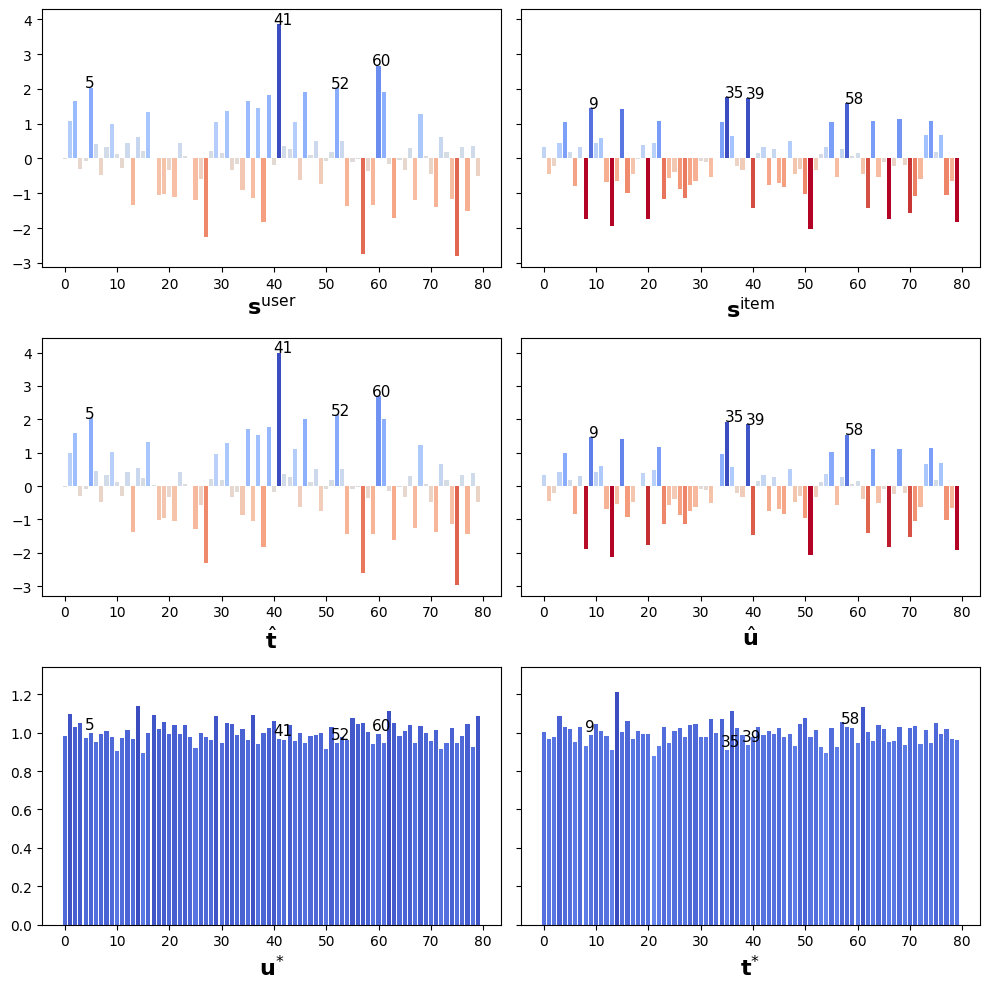

In [148]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

def weight_visualization(u_sim_mtx: np.ndarray, u_proj: np.ndarray, i_sim_mtx: np.ndarray, i_proj: np.ndarray,
                         annotate_top_k: int = 3, item_ptotos_interpret=None, user_ptotos_interpret=None, item_id=None,
                         verbose_proto_info=False, path_save_fig=None):
    """
    Creates weight visualization plots which is used to explain the recommendation of ProtoMF
    :param u_sim_mtx,...,i_proj: vectors that are obtained by the UI-PROTOMF model given the user and item pair.
    :param annotate_top_k: how many of the highest logits need to be annotated
    """

    rescale = lambda y: 1 - ((y + np.max(y)) / (np.max(y) * 2))

    def compute_ylims(array):
        y_lim_max = np.max(array) * (1 + 1 / 9)
        y_lim_min = np.min(array) * (1 + 1 / 9)
        return y_lim_min, y_lim_max

    # Computing the logits

    u_prods = u_sim_mtx * i_proj
    i_prods = i_sim_mtx * u_proj

    u_dot = u_prods.sum()
    i_dot = i_prods.sum()

    i_n_prototypes = i_sim_mtx.shape[-1]
    u_n_prototypes = u_sim_mtx.shape[-1]

    # Rescale the plots according to the number of prototypes
    i_vis_ratio = i_n_prototypes / (i_n_prototypes + u_n_prototypes)
    u_vis_ratio = 1 - i_vis_ratio

    # Compute max and mins of the visualization of the logits
    prods_lims = compute_ylims(np.concatenate([u_prods, i_prods]))
    proj_lims = compute_ylims(np.concatenate([u_proj, i_proj]))
    sim_mtx_lims = (0, compute_ylims(np.concatenate([u_sim_mtx, i_sim_mtx]))[1])

    # Plotting the users
    u_fig, u_axes = plt.subplots(3, 2, sharey='row', dpi=100, figsize=(20 * u_vis_ratio, 10))
    u_x = np.arange(u_n_prototypes)

    bars_u_prods = u_axes[0][0].bar(u_x, u_prods, color=plt.get_cmap('coolwarm')(rescale(u_prods)))
    bars_i_proj = u_axes[1][0].bar(u_x, i_proj, color=plt.get_cmap('coolwarm')(rescale(i_proj)))
    bars_u_sim_mtx = u_axes[2][0].bar(u_x, u_sim_mtx, color=plt.get_cmap('coolwarm')(rescale(u_sim_mtx)))

    u_axes[0][0].set_ylim(prods_lims)
    u_axes[1][0].set_ylim(proj_lims)
    u_axes[2][0].set_ylim(sim_mtx_lims)

    u_annotate_protos = np.argsort(-u_prods)[:annotate_top_k]
    for idx, bars in enumerate([bars_u_prods, bars_i_proj, bars_u_sim_mtx]):
        for u_annotate_idx in u_annotate_protos:
            bar = bars[u_annotate_idx]
            label_x = bar.get_x() - 0.8
            label_y = bar.get_height() + (2e-2 if idx == 2 else 1e-2)
            u_axes[idx][0].annotate(f'{u_annotate_idx}', (label_x, label_y), fontsize=11)

    u_axes[0][0].set_xlabel(r'$ {\mathbf{s}}^{\mathrm{user}}$', fontsize=16)
    u_axes[1][0].set_xlabel('$ \hat{\mathbf{t}} $', fontsize=16)
    u_axes[2][0].set_xlabel('$ \mathbf{u}^{*} $', fontsize=16)
    plt.tight_layout()
    plt.plot()

    # Plotting the items
    #i_fig, i_axes = plt.subplots(3, 1, sharey='row', dpi=100, figsize=(i_vis_ratio * 8, 8))
    i_x = np.arange(i_n_prototypes)

    bars_i_prods = u_axes[0][1].bar(i_x, i_prods, color=plt.get_cmap('coolwarm')(rescale(i_prods)))
    bars_u_proj = u_axes[1][1].bar(i_x, u_proj, color=plt.get_cmap('coolwarm')(rescale(u_proj)))
    bars_i_sim_mtx = u_axes[2][1].bar(i_x, i_sim_mtx, color=plt.get_cmap('coolwarm')(rescale(i_sim_mtx)))

    u_axes[0][1].set_ylim(prods_lims)
    u_axes[1][1].set_ylim(proj_lims)
    u_axes[2][1].set_ylim(sim_mtx_lims)

    # Annotations
    i_annotate_protos = np.argsort(-i_prods)[:annotate_top_k]
    for idx, bars in enumerate([bars_i_prods, bars_u_proj, bars_i_sim_mtx]):
        for i_annotate_idx in i_annotate_protos:
            bar = bars[i_annotate_idx]
            label_x = bar.get_x() + (-0.8 if idx == 2 else +0)
            label_y = bar.get_height() + (2e-2 if idx == 2 else 1e-2)
            u_axes[idx][1].annotate(f'{i_annotate_idx}', (label_x, label_y), fontsize=11)

    u_axes[0][1].set_xlabel('$ \mathbf{s}^{\mathrm{item}} $', fontsize=16)
    u_axes[1][1].set_xlabel('$ \hat{\mathbf{u}} $', fontsize=16)
    u_axes[2][1].set_xlabel('$ \mathbf{t}^{*} $', fontsize=16)

    plt.tight_layout()
    plt.plot()


    if item_ptotos_interpret is not None and user_ptotos_interpret is not None and verbose_proto_info==True:
        if item_id:
          item_data = item_ptotos_interpret[item_ptotos_interpret.item_id==item_id]
          print(f'Film {item_id}:{item_data.movienm.item()}, ganre:{item_data.genreid.item()}\n')
        for i in range(annotate_top_k):
          text = user_ptotos_interpret[user_ptotos_interpret.proto_id==u_annotate_protos[i]][['genreid','movienm']].to_numpy()
          print(f'U-proto {u_annotate_protos[i]}: {text}\n')
        for i in range(annotate_top_k):
          text = item_ptotos_interpret[item_ptotos_interpret.proto_id==i_annotate_protos[i]][['genreid','movienm']].to_numpy()
          print(f'I-proto {i_annotate_protos[i]}: {text}\n')

    if path_save_fig:
        plt.savefig(path_save_fig, format='pdf')

weight_visualization(u_sim_mtx=u_sim_mtx[user_id], u_proj=u_proj[user_id], i_sim_mtx=i_sim_mtx[item_id], i_proj=i_proj[item_id],
                         annotate_top_k=4, item_ptotos_interpret=item_interp_df,user_ptotos_interpret=user_interp_df, item_id=item_id, verbose_proto_info=True)